In [ ]:
import os 
from collections import Counter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import seaborn as sns
from zipfile import ZipFile
from tqdm import tqdm
import warnings 
warnings.filterwarnings("ignore")
import random
import cv2
from sklearn.model_selection import KFold
from imgaug import augmenters as iaa
import glob
import sys

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
## Download images zip file

#!wget --header="Host: storage.googleapis.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/88.0.4324.182 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9,mr;q=0.8" --header="Referer: https://www.kaggle.com/" "https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/13032/862545/compressed/train.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1614258678&Signature=r2IuRO%2BnPq6nqNfiZAh6vqTuPoKT5906Zs9tJ4hZeWpESKzVMywSWL%2F1%2BSoglGHxrZ2vDKYLbMd77U81nZvJguUfPDo42A1HjtIVg3ZDjUybvqBPmxiNu%2F0vd54yjju91jfvweooEt5ZYsVq%2FpU32Kf6aZbYGZJNMP8RkYyTuD%2FHHz7PGj5bN7psoZbeZvIxbzCCZu8wDVHTfkWtQawWMceCrLF%2FGYcMvuRj1iDOXd8PqV3NpjtRPuLwqN05oaGPNdBUXu2n9wnlIjtnwzKw8vDi%2F3AYk6m7plWx%2FR%2BRd7HUipJcphxMit5CWO92a4JNO2VGIlXDtDwRsU3J0mxzHg%3D%3D&response-content-disposition=attachment%3B+filename%3Dtrain.zip" -c -O 'train.zip'
#!mv train.zip train_images.zip
#!mv 'train_images.zip' '/content/drive/MyDrive/fashion_data/train_images.zip' 

--2021-02-25 07:54:36--  https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/13032/862545/compressed/train.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1614258678&Signature=r2IuRO%2BnPq6nqNfiZAh6vqTuPoKT5906Zs9tJ4hZeWpESKzVMywSWL%2F1%2BSoglGHxrZ2vDKYLbMd77U81nZvJguUfPDo42A1HjtIVg3ZDjUybvqBPmxiNu%2F0vd54yjju91jfvweooEt5ZYsVq%2FpU32Kf6aZbYGZJNMP8RkYyTuD%2FHHz7PGj5bN7psoZbeZvIxbzCCZu8wDVHTfkWtQawWMceCrLF%2FGYcMvuRj1iDOXd8PqV3NpjtRPuLwqN05oaGPNdBUXu2n9wnlIjtnwzKw8vDi%2F3AYk6m7plWx%2FR%2BRd7HUipJcphxMit5CWO92a4JNO2VGIlXDtDwRsU3J0mxzHg%3D%3D&response-content-disposition=attachment%3B+filename%3Dtrain.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.195.128, 74.125.20.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18956138092 (18G) [application/zip]
Saving to: ‘train.zip’

train.zip           100%[===

In [ ]:
## Download other files such as label_description.json and mask csv file using kaggle api

#os.environ["KAGGLE_USERNAME"] = "*******"
#os.environ['KAGGLE_KEY'] = "**************" 
#!kaggle competitions download -c imaterialist-fashion-2019-FGVC6

After running the below cell we will have label_descriptions in label_description.json file, mask csv file in train_csv.csv file,zip image file in train_images.zip file 

In [ ]:
!rm -rf sample_data
!cp "/content/drive/MyDrive/fashion_data/label_descriptions.json" "label_descriptions.json"
!unzip "/content/drive/MyDrive/fashion_data/train.zip"  #get mask csv file
!mv train.csv train_csv.csv

Archive:  /content/drive/MyDrive/fashion_data/train.zip
  inflating: train.csv               


In [ ]:
df = pd.read_csv('train_csv.csv')
df.head()

,ImageId,EncodedPixels,Height,Width,ClassId
0,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,6068157 7 6073371 20 6078584 34 6083797 48 608...,5214,3676,6
1,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,6323163 11 6328356 32 6333549 53 6338742 75 63...,5214,3676,0
2,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,8521389 10 8526585 30 8531789 42 8537002 46 85...,5214,3676,28
3,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,12903854 2 12909064 7 12914275 10 12919485 15 ...,5214,3676,31
4,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,10837337 5 10842542 14 10847746 24 10852951 33...,5214,3676,32


## Description of Label File :
The file contain three main fields, namely Info, Categories and Attributes. In an info field we have information such as year, data version and description about the file. In the categories field we have provided with information about each category that is present in the dataset it has 4 subfields defining category namely id, name, supercategory , level. for example, ['id': 0, 'name': 'shirt, blouse', 'supercategory': 'upperbody', 'level': 2]. Third field provides information about Attributes. We will only work with categories.

In [ ]:
labels_file = json.load(open('label_descriptions.json')) 
for x in labels_file :
    print('####', x, '\n', labels_file[x])


#Analysis and Preprocessing

1) As we can see from the below that there are total 331213 entries in the dataset and total unique entries are 45195. For each class present in the image there is seperate entry present in the dataset.

In [ ]:
print('Total entries = ', len(df))
print('Total Unique entries = ', len(set(df['ImageId'])))

Total entries =  331213
Total Unique entries =  45195


2)Mismatched Height or Width <br>
     In the same image there could be multiple classes and multiple instances of those classes. By understanding format of the given csv file we get to know that there is one entry for each instance. So, the image will be present in multiple rows and the Height and Width information of the image is important during decoding encoded mask information we have to be sure that each entry of an image have same height and width to do that we will join df with itself (self join).

In [ ]:
joint_df = pd.merge(df, df, on = 'ImageId', how = 'inner')

lenn_height = len(joint_df[joint_df.Height_x != joint_df.Height_y])
lenn_width = len(joint_df[joint_df.Width_x != joint_df.Width_y])

print('Mismatched count = ', lenn_height, lenn_width)

Mismatched count =  0 0


3) For any Neural Network we need images to be of same size. By doing percentile analysis we can see that for height= 4912 and widht = 3744 will preserve 90% the data. But in order for model to work better will keep small image size as 512 * 512.

In [ ]:
print('Height Percentiles :')
for i in range(1, 100, 10) :
    print("{}th percentile = ".format(i), np.percentile(df['Height'], i))

print('\nWidth Percentiles :')
for i in range(1, 100, 10) :
    print("{}th percentile = ".format(i), np.percentile(df['Width'], i))

Height Percentiles :
1th percentile =  500.0
11th percentile =  794.0
21th percentile =  1000.0
31th percentile =  1080.0
41th percentile =  1356.0
51th percentile =  1607.0
61th percentile =  2359.0
71th percentile =  3000.0
81th percentile =  3436.0
91th percentile =  4912.0

Width Percentiles :
1th percentile =  375.0
11th percentile =  600.0
21th percentile =  683.0
31th percentile =  800.0
41th percentile =  1000.0
51th percentile =  1200.0
61th percentile =  1762.0
71th percentile =  2001.0
81th percentile =  2841.0
91th percentile =  3744.0


4) As mentioned in the description file some categories have atributes. We found that only 3% entries have atributes it is better to have these entries removed in order to increase the accuracy.

In [ ]:
atribute_per = len(df[df['ClassId'].str.contains('_')])/len(df)*100
print('Atribute Percentage = ',atribute_per)
df = df[~df.ClassId.str.contains('_')]
print('Length After Removal = ', len(df))

Atribute Percentage =  3.4717840181393846
Length After Removal =  319714


5) In segmentation task, masking/classifying the small region where the object of intrest is present becomes very challeging. Hence we have first calculated number of pixel each region contains and then if the region has small number of pixels lets say 50 we will consider it for removal.

In [ ]:
df['EncodedPixels'] = df['EncodedPixels'].str.split()

pixel_count = []
for j, annotation in enumerate(df.EncodedPixels) :
    lenn = 0
    for i, len_at_step in enumerate(annotation[1::2]) :
        lenn += int(len_at_step)
    pixel_count.append(lenn)
    del lenn

print('Min Count = ', min(pixel_count) , 'Max Count = ', max(pixel_count))
df['pixel_count'] = pixel_count 
## removing small regions
print('Length Before = ', len(df))
df = df[df.pixel_count > 50]
print('Length After = ', len(df)) 
del pixel_count

Min Count =  1 Max Count =  18407571
Length Before =  319714
Length After =  316338


6) From the bar graph we can see that, categories like umbrella, jacket, sweater, jumpsuit have very high mean pixel_count where as, rivel, buckle, zipper categories have very low mean pixel_count. The varience in pixel_count of sweater, umbrella, cape, cardigan is very high meaning they are present in images with varying sizes and the categories like glasses, watches, glove, leg warmer have less varience meaning they typically have almost same sizes.

([<matplotlib.axis.YTick at 0x7fa164cce350>,
 [Text(0, 0, 'shirt, blouse'),
  Text(0, 0, 'top, t-shirt, sweatshirt'),
  Text(0, 0, 'sweater'),
  Text(0, 0, 'cardigan'),
  Text(0, 0, 'jacket'),
  Text(0, 0, 'vest'),
  Text(0, 0, 'pants'),
  Text(0, 0, 'shorts'),
  Text(0, 0, 'skirt'),
  Text(0, 0, 'coat'),
  Text(0, 0, 'dress'),
  Text(0, 0, 'jumpsuit'),
  Text(0, 0, 'cape'),
  Text(0, 0, 'glasses'),
  Text(0, 0, 'hat'),
  Text(0, 0, 'headband, head covering, hair accessory'),
  Text(0, 0, 'tie'),
  Text(0, 0, 'glove'),
  Text(0, 0, 'watch'),
  Text(0, 0, 'belt'),
  Text(0, 0, 'leg warmer'),
  Text(0, 0, 'tights, stockings'),
  Text(0, 0, 'sock'),
  Text(0, 0, 'shoe'),
  Text(0, 0, 'bag, wallet'),
  Text(0, 0, 'scarf'),
  Text(0, 0, 'umbrella'),
  Text(0, 0, 'hood'),
  Text(0, 0, 'collar'),
  Text(0, 0, 'lapel'),
  Text(0, 0, 'epaulette'),
  Text(0, 0, 'sleeve'),
  Text(0, 0, 'pocket'),
  Text(0, 0, 'neckline'),
  Text(0, 0, 'buckle'),
  Text(0, 0, 'zipper'),
  Text(0, 0, 'applique'),
 

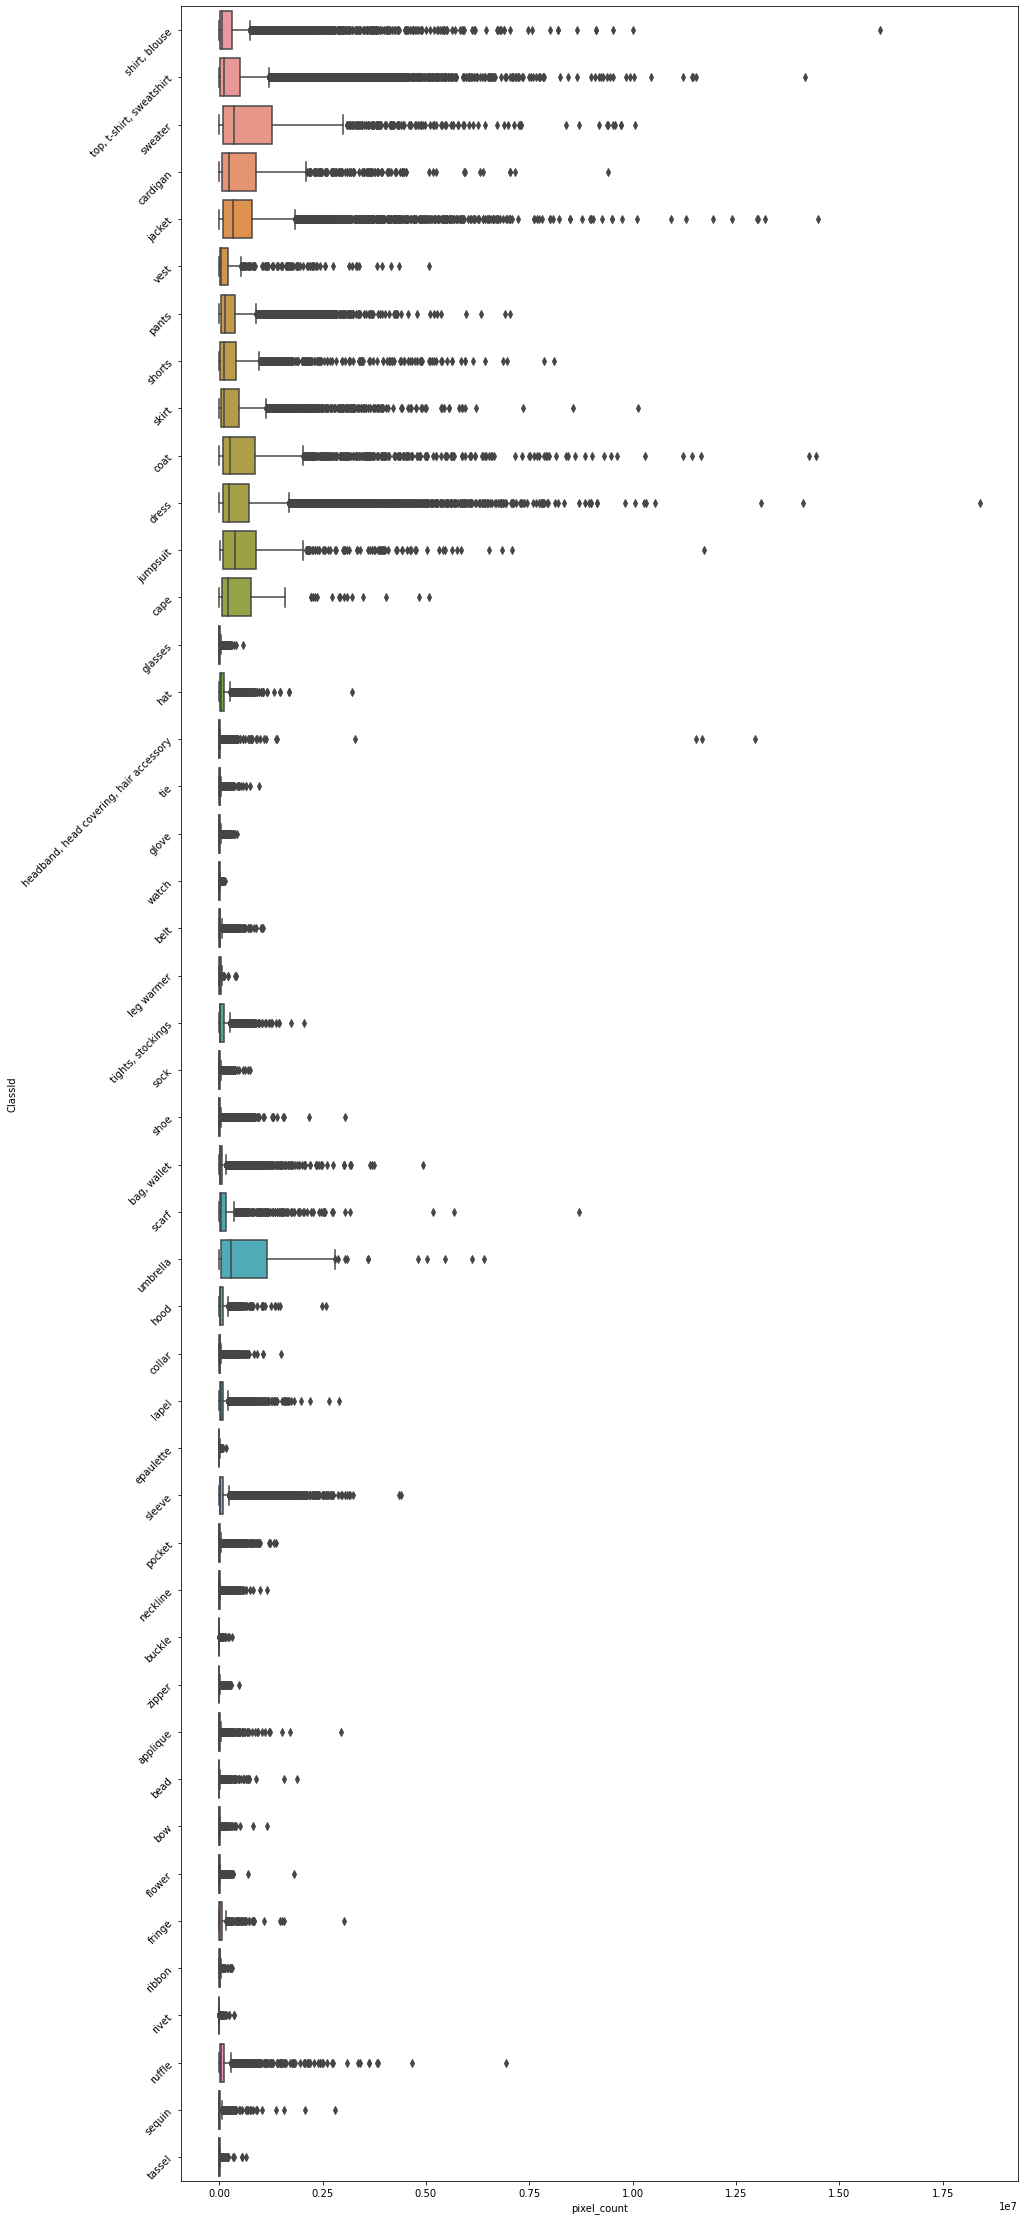

In [ ]:
l = list(range(0, 46))
new_l = []
for x in l :
    new_l.append(str(x))
categories = pd.DataFrame(labels_file['categories'])   
fig , ax = plt.subplots(figsize = (15, 40))
ax = sns.boxplot(y = 'ClassId', x = 'pixel_count', data = df, orient = 'h', order = new_l)
locs, labels = plt.yticks()
plt.yticks(locs, categories.name.values, rotation=45)

7) We can see that categories like sleeve, shoes are present in very large numbers where as categories like leg warmer, cape, umbrella, ribbon are present in very less number. We have data imbalance problem we will choose to remove some of the categories whose count is less than some threshold.

([<matplotlib.axis.YTick at 0x7fa164eb9410>,
 [Text(0, 0, 'shirt, blouse'),
  Text(0, 0, 'top, t-shirt, sweatshirt'),
  Text(0, 0, 'sweater'),
  Text(0, 0, 'cardigan'),
  Text(0, 0, 'jacket'),
  Text(0, 0, 'vest'),
  Text(0, 0, 'pants'),
  Text(0, 0, 'shorts'),
  Text(0, 0, 'skirt'),
  Text(0, 0, 'coat'),
  Text(0, 0, 'dress'),
  Text(0, 0, 'jumpsuit'),
  Text(0, 0, 'cape'),
  Text(0, 0, 'glasses'),
  Text(0, 0, 'hat'),
  Text(0, 0, 'headband, head covering, hair accessory'),
  Text(0, 0, 'tie'),
  Text(0, 0, 'glove'),
  Text(0, 0, 'watch'),
  Text(0, 0, 'belt'),
  Text(0, 0, 'leg warmer'),
  Text(0, 0, 'tights, stockings'),
  Text(0, 0, 'sock'),
  Text(0, 0, 'shoe'),
  Text(0, 0, 'bag, wallet'),
  Text(0, 0, 'scarf'),
  Text(0, 0, 'umbrella'),
  Text(0, 0, 'hood'),
  Text(0, 0, 'collar'),
  Text(0, 0, 'lapel'),
  Text(0, 0, 'epaulette'),
  Text(0, 0, 'sleeve'),
  Text(0, 0, 'pocket'),
  Text(0, 0, 'neckline'),
  Text(0, 0, 'buckle'),
  Text(0, 0, 'zipper'),
  Text(0, 0, 'applique'),
 

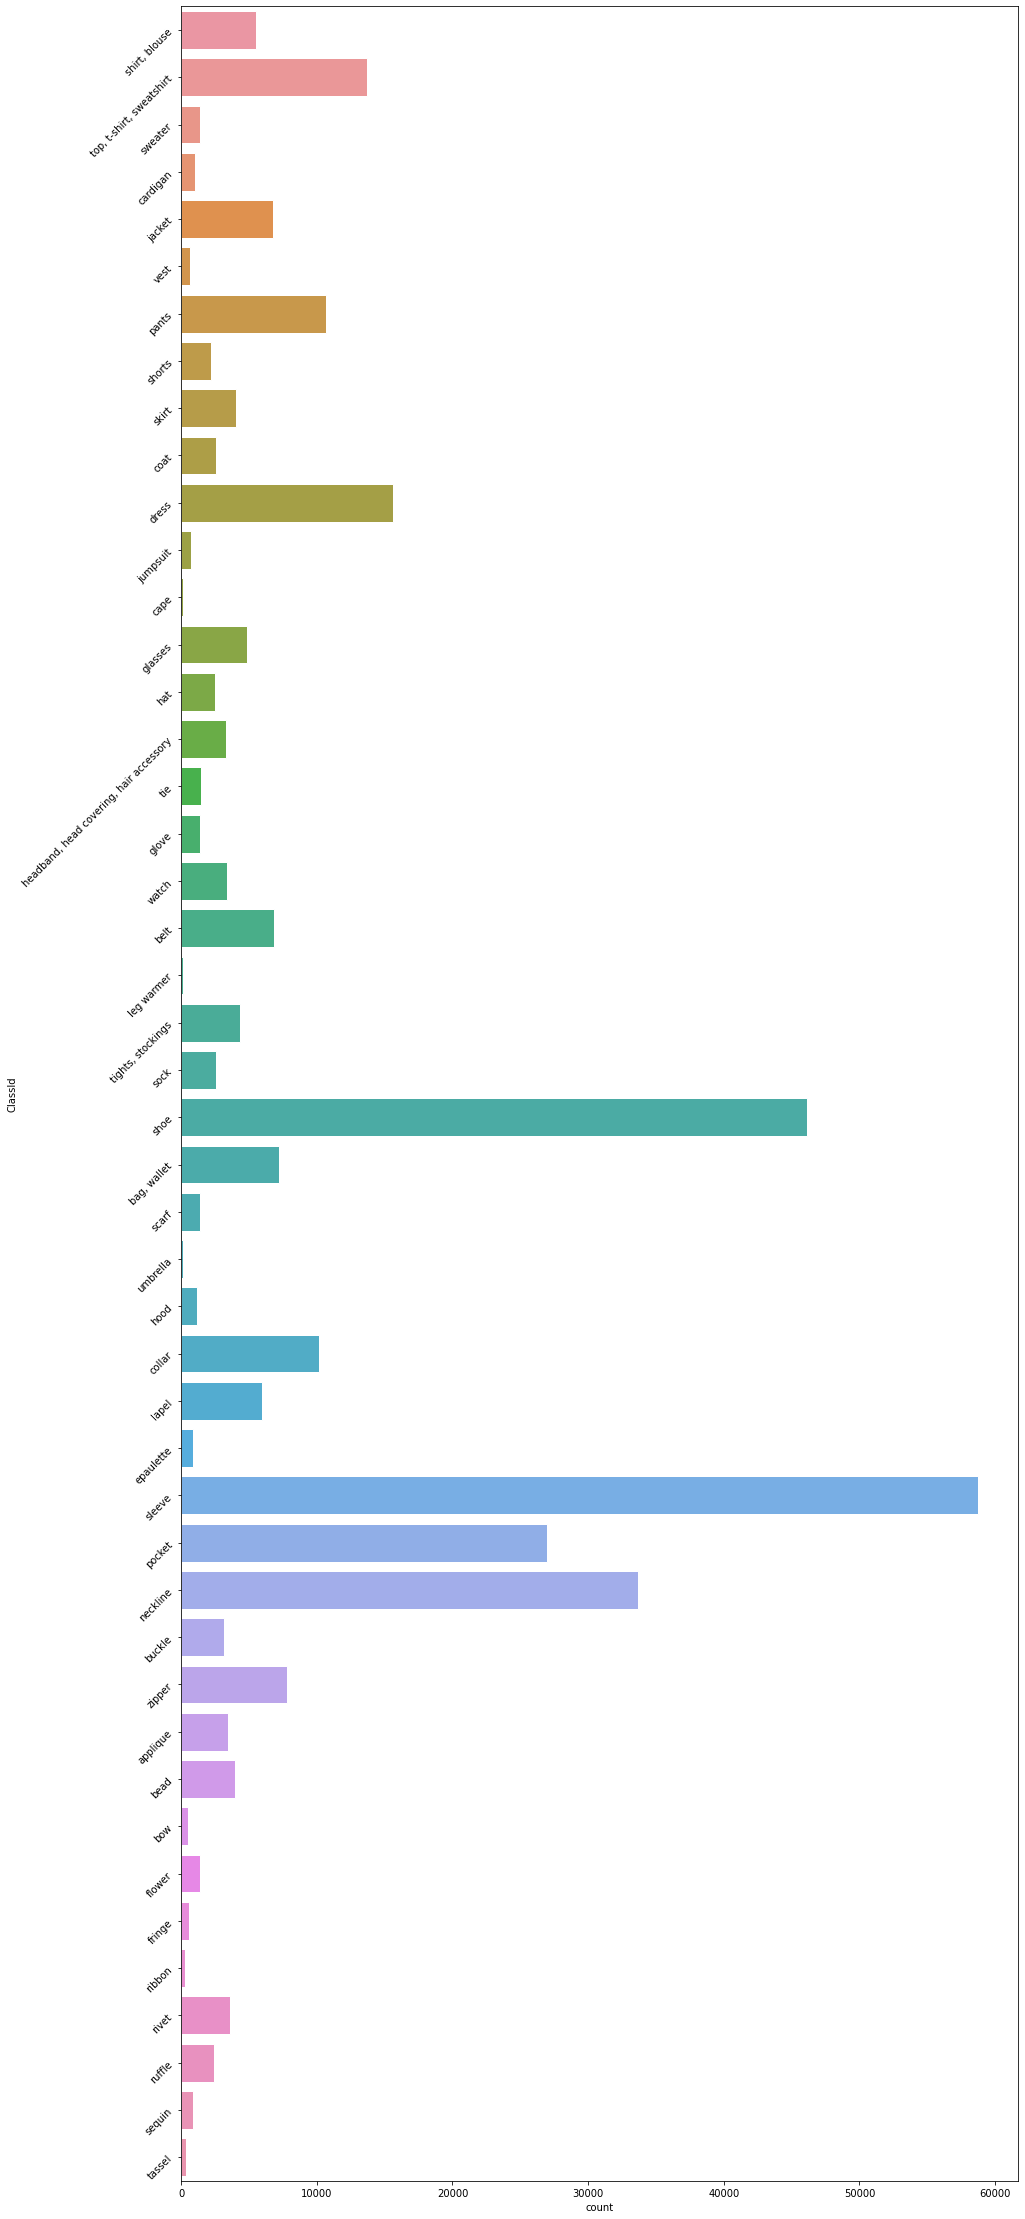

In [ ]:
l = list(range(0, 46))
new_l = []
for x in l :
    new_l.append(str(x))
categories = pd.DataFrame(labels_file['categories'])
fig , ax = plt.subplots(figsize = (15, 40))
sns.set_theme(style="darkgrid")
ax = sns.countplot(y = df['ClassId'],  order = new_l)
locs, labels = plt.yticks()
plt.yticks(locs, categories.name.values, rotation=45)


8) Duplicate Masks : <br>
   Lets analyze duplicate entries, We consider entry to be duplicate if for same image and same classid it has same mask, using this defination we didnt get any duplicate entry. Next we considered mask to be corrupted if for same image, the same mask is used for different classes.The corrupted entries are removed. 

In [ ]:
print('Lenght before duplicates', len(df))
df['EncodedPixels'] = df['EncodedPixels'].apply(lambda x : ' '.join(x))
df.drop_duplicates(subset = ['ImageId', 'EncodedPixels', 'ClassId'], keep = 'first')
print('Length After dropping =', len(df))

Lenght before duplicates 316338
Length After dropping = 316338


In [ ]:
new_df = df.groupby(["EncodedPixels", "ImageId"]).count().reset_index()
new_df = new_df[new_df.ClassId > 1]
df = df[~(df.ImageId.isin(new_df.ImageId) & df.EncodedPixels.isin(new_df.EncodedPixels))]
print('Lenght after dropping corrupted masks', len(df))
del new_df

Lenght after dropping corrupted masks 315328


9) Removing Uncommon Categories : <br>
   Some of the categories are rarely found in India. So, these categories wont produce that much profit to the companies hence I chose have them removed, categories such as collar, lapel, sleeve will be removed and also the classes whose instances count is less than some will also be removed.




In [ ]:
class_count = Counter(df.ClassId)
selected_classes = []
threshold = 2000

### The classes such that, number of instances < Threshold in the whole dataset will also be removed
for cls, count in class_count.items():
    if count > threshold :            
        selected_classes.append(cls)

uncommon_cat = set(['collar' , 'lapel', 'sleeve', 'pocket', 'neckline', 'buckle', 'applique', 'bead' ])
uncommon_ids = set(['28', '29', '31', '32', '33', '34', '36', '37'])
selected_classes = set(selected_classes) - uncommon_ids  ## Removing uncommon categories
new_df = df[df.ClassId.isin(selected_classes)].copy()
del df
print('Lenght After Removal = ', len(new_df))

Lenght After Removal =  155507


In [ ]:
# some classes have been removed so, we need to do remapping.
class_number = 0
mapping = {}
selected_classes = sorted([int(i) for i in selected_classes])
for classx in sorted(selected_classes) :
    mapping[str(classx)] = (str(class_number), labels_file['categories'][classx]['name'])
    class_number += 1
new_df.ClassId = new_df.ClassId.apply(lambda x : mapping[x][0])

class_label = []
for key, val in mapping.items() : 
    class_label.append(val[1])

print(class_label)
df = new_df.copy()
del new_df

['shirt, blouse', 'top, t-shirt, sweatshirt', 'jacket', 'pants', 'shorts', 'skirt', 'coat', 'dress', 'glasses', 'hat', 'headband, head covering, hair accessory', 'watch', 'belt', 'tights, stockings', 'sock', 'shoe', 'bag, wallet', 'zipper', 'rivet', 'ruffle']


In [ ]:
image_df = df.groupby('ImageId')['EncodedPixels', 'ClassId'].agg(lambda x: list(x)).reset_index()
size_df = df.groupby('ImageId')['Height', 'Width'].agg('first').reset_index()
image_df = pd.merge(image_df, size_df, how = 'inner', on = 'ImageId')
del df

10)Sanity Checks : <br>
A)The length of mask corresponding to a perticular image must be equal to length of class ids that image have.

In [ ]:
image_df['encoded_len'] = image_df.EncodedPixels.apply(lambda x : len(x))
image_df['class_len'] = image_df.ClassId.apply(lambda x : len(x))
print('Length Before', len(image_df))
image_df = image_df[image_df.encoded_len == image_df.class_len]
print('Length After', len(image_df))

Length Before 43561
Length After 43561


B) The encoded mask list is based on pixel number. Lets understand this by example suppose you have an image of size (256 * 256), after flattening this image we will get one dimensional array having pixel numbers ranging from 1 to (256 * 256) flattening can be done be in two ways 'C' type used in 'C' language (row wise) or 'F' type used in FORTRAN (column wise) language they have used 'F' type flattening. Using this pixel numbers encoded mask lists for each instance are built for example lets say shoe instance is present at pixel number [1, 2, 3, 4, 89, 90, 91] then encoded mask list will be [1, 4, 89, 3] meaning from pixel number 1 to 1 + (3 - 1) and pixel number 89 to 89 + (3 -1) the shoe instance is present we can see that pixel number present in the encoded mask must be less than or equal to (256 * 256 that is 65536) and that will be our next sanity check.

In [ ]:
from functools import reduce
corrupt_image_count = len(image_df[image_df.EncodedPixels.apply(
                      lambda x : max([int(val) for val in reduce(lambda p, q : p + ' ' + q, x).split()])) > (image_df.Height * image_df.Width) ])

print('CORRUPTED IMAGES COUNT = ', corrupt_image_count) 


CORRUPTED IMAGES COUNT =  0


11)Disk Constraints : <br>
   As there are around 45000 images in the dataset. Its not possible to unzip the whole file into google colab disk. We need to be selective about which images we should consider to work with. We have decided to download only 50% images. In the selection process we will take images with more number of distinct classes. For example if we have an image1 with 15 distinct classes and an image2 with 4 distinct number of classes present in it obviously image1 will be taken as it is an information rich image.

In [ ]:
## Lets first create new column distinct_class_count
image_df['distinct_class_count'] = image_df.ClassId.apply(lambda x : len(set(x)))
for i in range(1, 100, 10) :
    print("{}th percentile = ".format(i), np.percentile(image_df['distinct_class_count'], i))
print('\n######\n')

##  We will take only 50% of 45000 total images so we have to remove 50% of the images. The distinct class count value below which 
##  there are 50% of the images is 3. so we will use below condition to get approximately 50% images.

print('Lenght Before', len(image_df))
image_df_new = image_df[image_df.distinct_class_count >= 3].copy()
print('Length After', len(image_df_new))
del image_df

1th percentile =  1.0
11th percentile =  1.0
21th percentile =  1.0
31th percentile =  2.0
41th percentile =  2.0
51th percentile =  3.0
61th percentile =  3.0
71th percentile =  4.0
81th percentile =  4.0
91th percentile =  5.0

######

Lenght Before 43561
Length After 22155


12) Visualization of Final Class Distribution : <br>
    We can see in the diagram that the number of instances of each class in the dataset are almost the same except for shoes class. The distribution of classes in the dataset after doing EDA is really nice so, we can conclude that we did pretty well EDA.

([<matplotlib.axis.YTick at 0x7fa4b0a8c150>,
 [Text(0, 0, 'shirt, blouse'),
  Text(0, 0, 'top, t-shirt, sweatshirt'),
  Text(0, 0, 'jacket'),
  Text(0, 0, 'pants'),
  Text(0, 0, 'shorts'),
  Text(0, 0, 'skirt'),
  Text(0, 0, 'coat'),
  Text(0, 0, 'dress'),
  Text(0, 0, 'glasses'),
  Text(0, 0, 'hat'),
  Text(0, 0, 'headband, head covering, hair accessory'),
  Text(0, 0, 'watch'),
  Text(0, 0, 'belt'),
  Text(0, 0, 'tights, stockings'),
  Text(0, 0, 'sock'),
  Text(0, 0, 'shoe'),
  Text(0, 0, 'bag, wallet'),
  Text(0, 0, 'zipper')])

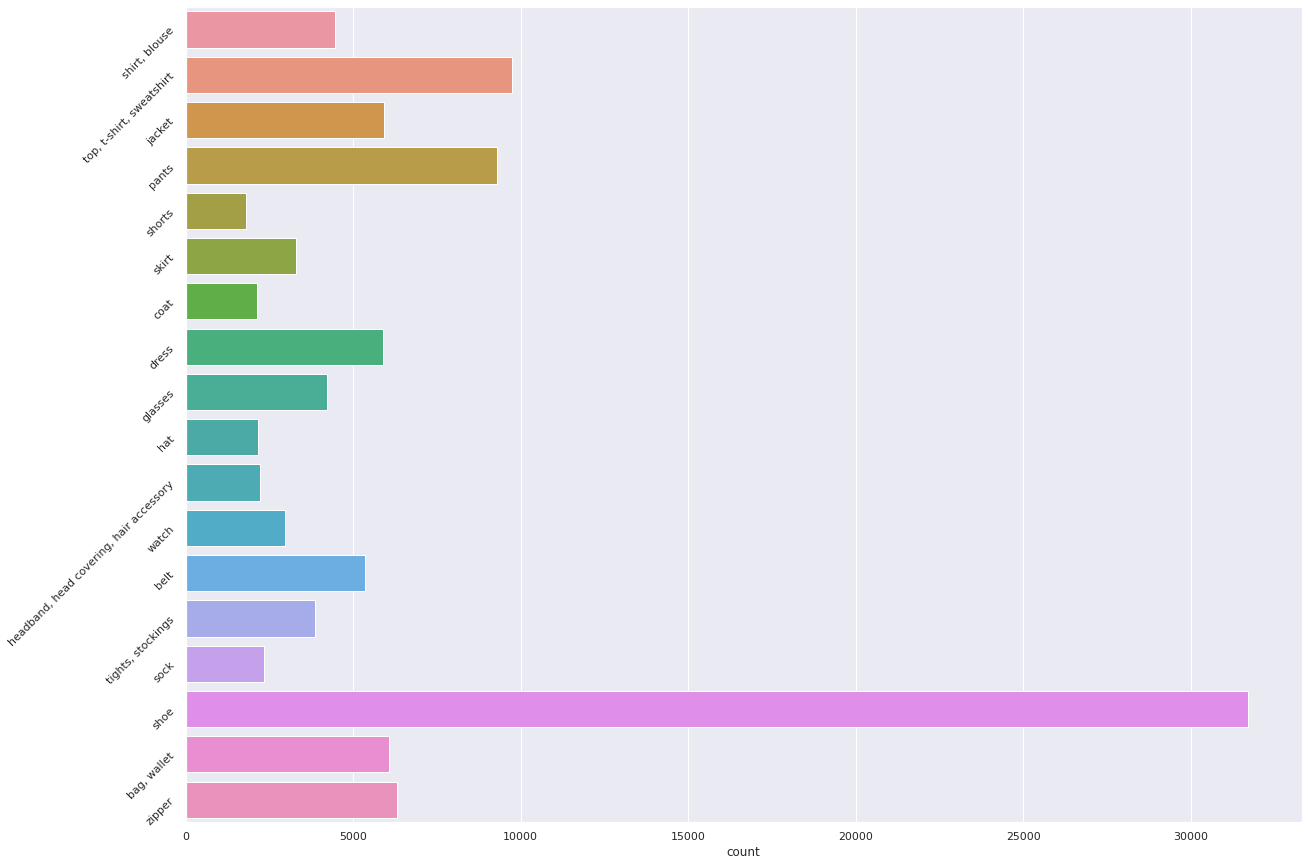

In [ ]:
plt.figure(figsize = (20, 15))
classes = []
for li in image_df_new.ClassId :
    classes += li

new_l = []
for x in list(range(0, 18)) :
    new_l.append(str(x))
sns.countplot(y = classes, order = new_l)
locs, labels = plt.yticks()
plt.yticks(locs, class_label, rotation=45)

13)Saving Files to Drive

In [ ]:
image_df_new.to_csv('final_csv.csv', index = False)
!cp final_csv.csv '/content/drive/MyDrive/fashion_data/final_csv.csv'   ### Save the preprocessed csv file to drive

In [ ]:
## Unzip the images whose id in final_csv.csv file from train_images.zip 
## file into '/content/drive/MyDrive/fashion_data/ImageTrain' folder run it once only

!rm -rf '/content/drive/MyDrive/fashion_data/ImageTrain'
with ZipFile('/content/drive/MyDrive/fashion_data/train_images.zip', 'r') as image_zip:
    for filename in tqdm(image_df_new.ImageId.values) :
        image_zip.extract(filename, '/content/drive/MyDrive/fashion_data/ImageTrain')  ### give folder path where to extract the file

100%|██████████| 22155/22155 [09:47<00:00, 37.69it/s]


In [ ]:
### If you have already created final_csv file run from here.
image_df_new = pd.read_csv('/content/drive/MyDrive/fashion_data/final_csv.csv', converters={'EncodedPixels': eval, 'ClassId' :eval})
print(len(image_df_new))

22155


14) Visualization of mask : <br>
    At this point of time we have with us selected, downloaded in the drive. We will pick five imagas from the drive and draw their mask to understand what we have as a data.


In [ ]:
class_label = ['shirt, blouse', 'top, t-shirt, sweatshirt', 'jacket', 'pants', 'shorts', 'skirt', 'coat', 'dress', 'glasses', 'hat', 'headband, head covering, hair accessory', 'watch', 'belt', 'tights, stockings', 'sock', 'shoe', 'bag, wallet', 'zipper', 'rivet', 'ruffle']

def load_mask(id):
    info = image_df_new
    height = info.iloc[id]['Height']
    width = info.iloc[id]['Width']
    encoded_pixels_list = info.iloc[id]['EncodedPixels']   
    labels = [int(x) for x in info.iloc[id]['ClassId']]      
    mask = np.zeros((height, width, len(encoded_pixels_list)), dtype=np.uint8)
        
    for m, annotation in enumerate(encoded_pixels_list):
        sub_mask = np.full(height * width, 0, dtype=np.uint8)
        annotation = [int(x) for x in annotation.split(' ')]
            
        for i, start_pixel in enumerate(annotation[::2]):
            start_pixel -= 1
            sub_mask[start_pixel : start_pixel+annotation[2*i+1]] = 1

        sub_mask = sub_mask.reshape((height, width), order='F')

        mask[:, :, m] = sub_mask
    path = info.iloc[id]['ImageId']
    print(path)
    return mask, np.array(labels), path

num_images = 5
num_instances = 5

fig ,ax = plt.subplots(num_images, num_instances + 1, figsize=(15,15))  ## +1 for adding original image
for row in range(num_images) :
    rand_num = np.random.randint(0, len(image_df_new) - 1)
    mask, labels, path = load_mask(rand_num)
    path = '/content/drive/MyDrive/fashion_data/ImageTrain/' + str(path)
    print(path)
    img_current = cv2.imread(path)
    img_current = cv2.cvtColor(img_current, code = cv2.COLOR_BGR2RGB)
    ax[row][0].imshow(img_current)
    ax[row][0].grid(False) 
    ax[row][0].set_xticks([])
    ax[row][0].set_yticks([])
    ax[row][0].set_title('Original')
    min_img = min(num_instances, len(labels)) 
    #print(labels)
    for j in range(min_img):
        mask_temp = mask[:, :, j]
        label_temp = class_label[labels[j]]
        masked_image = img_current.copy()
        for channel in range(img_current.shape[-1]) :
            masked_image[:, :, channel] =  masked_image[:, :, channel] * mask_temp
        ax[row][j + 1].grid(False) 
        ax[row][j + 1].set_xticks([])
        ax[row][j + 1].set_yticks([])
        ax[row][j + 1].imshow(masked_image)
        del masked_image
        ax[row][j + 1].set_title(label_temp)

15) Different Augmentation : <br>
    The augmentation technique are helpful to get rid of the problem of overfitting and having very small dataset, generally deep learning models require lots of training data. The augmentation techniques performs different operations on given image such as, flip, rotate, translate, crop and add the transformed images to the existing dataset and hence increases the dataset size.We say the model is overfitting when it performs well on seen data but very poor on unseen data the overfitting also means remembering the whole training data just like humans if you have remembered answers without understanding and if in exam the problem comes with little variation from problem whose solution you remembered then you wont be able to solve it the same happens with deep learning models too. One way to discover overfitting is to plot the training and validation accuracy at each epoch during training. There are other technique such as regularization, transfer learning,drop outs to deal with overfitting problem but augmentation techniques outperforms all of them in case of image dataset. The augmentation techniques add distorted images to the dataset, the complex deep learning models tend to remember/overfit but with distored images it becomes difficult for the model to remember and in an attempt to remember distorted/complex data the model ends up being more generalized one as a by product. The augmentation techniques make model more robust. When applying augmentation we should keep in mind that the augmentattion is safe, here safe means the information post augmentation is preserved that is even after applying the transformation the information about mask/label must not get too much distorted that even humans wont be able to extract/understand it forget about DL model classifying or segmenting it when such cases happen.The different augmentation are available we will discuss few of them which we are going to use on our dataset, we will discuss things such as how the chosen transformation helps us, how we eliminated some of the transformations that will not improve our model and intution behind selecting good hypermeter available for techniques.

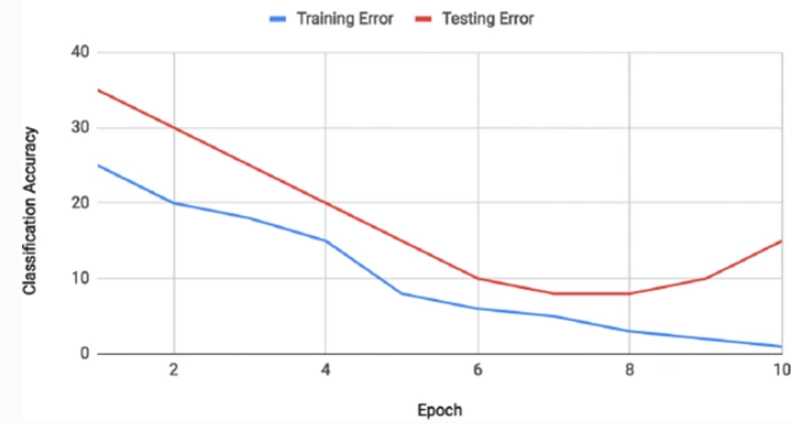

A)Flipping <br>
Horizontal axis flipping is much more common than flipping the vertical axis. We will apply it during training of the model. We can see that even after transformation it did not become difficult to identify shoes, glasses so, this transformation is safe.

In [ ]:
path = '/content/drive/MyDrive/fashion_data/ImageTrain/'
path = path + image_df_new.ImageId.iloc[random.randint(0, len(image_df_new) - 1)]
img_temp = cv2.imread(path)
img_temp = cv2.cvtColor(img_temp, code = cv2.COLOR_BGR2RGB)

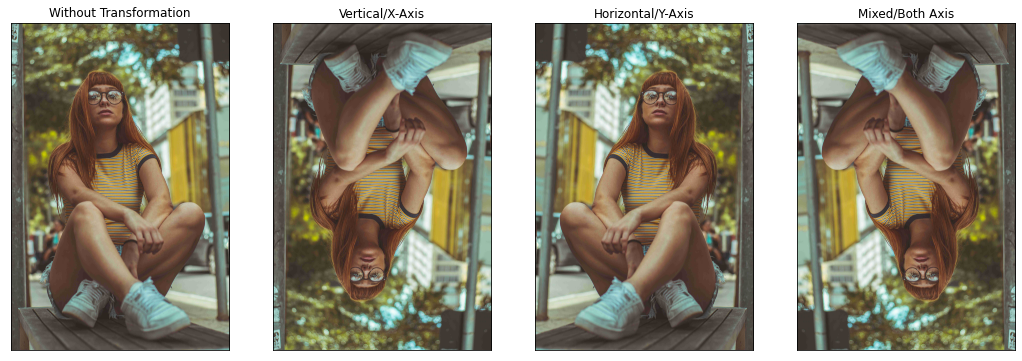

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 4, squeeze = False, figsize = (18, 8))
ax[0][0].grid(False) 
ax[0][0].set_xticks([])
ax[0][0].set_yticks([])
ax[0][0].imshow(img_temp)
ax[0][0].set_title('Without Transformation')
list_trans = []
trans_names = []

img_trans = cv2.flip(img_temp, 0) ## around x axis
list_trans.append(img_trans)
trans_names.append('Vertical/X-Axis')

img_trans = cv2.flip(img_temp, 1) ## along y axis
list_trans.append(img_trans)
trans_names.append('Horizontal/Y-Axis')

img_trans = cv2.flip(img_temp, -1) ## along both axis
trans_names.append('Mixed/Both Axis')
list_trans.append(img_trans)

for j, img in enumerate(list_trans) :
    ax[0][j + 1].set_title(trans_names[j])
    ax[0][j + 1].grid(False)
    ax[0][j + 1].set_xticks([])
    ax[0][j + 1].set_yticks([])
    ax[0][j + 1].imshow(img)


B)Rotation <br>
Rotation augmentations are done by rotating the image right or left on an axis between 1° and 359°. The safety of rotation augmentations is heavily determined by the rotation degree parameter. Slight rotations such as between 1 and 20 are useful but as the rotation degree increases, the information post augmentation may not be preserved. Here we are performing lossless rotation, the spatial dimension of the image may not preserved but it can be restored using resize function.

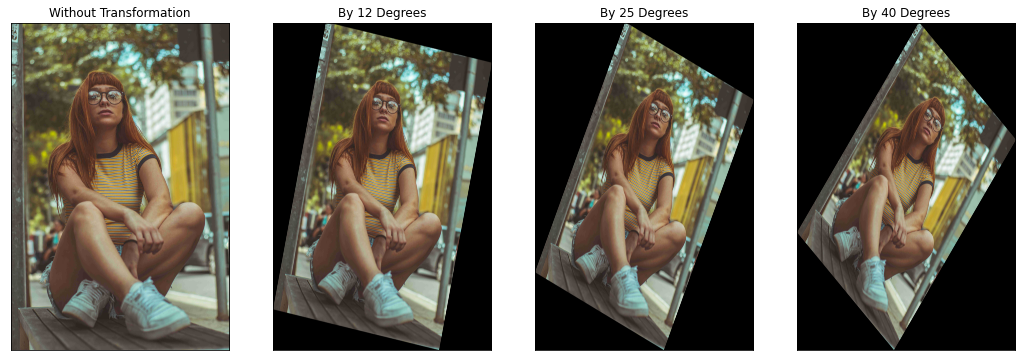

In [ ]:
import imutils
fig, ax = plt.subplots(nrows = 1, ncols = 4, squeeze = False, figsize = (18, 8)) 
ax[0][0].grid(False) 
ax[0][0].set_xticks([])
ax[0][0].set_yticks([])
ax[0][0].imshow(img_temp)
ax[0][0].set_title('Without Transformation')
list_trans = []
trans_names = []
img_trans = imutils.rotate_bound(img_temp, 12 )
img_trans = cv2.resize(img_trans, (img_temp.shape[1], img_temp.shape[0]), interpolation = cv2.INTER_NEAREST)
list_trans.append(img_trans)
trans_names.append('By 12 Degrees')

img_trans = imutils.rotate_bound(img_temp, 25)
img_trans = cv2.resize(img_trans, (img_temp.shape[1], img_temp.shape[0]), interpolation = cv2.INTER_NEAREST)
list_trans.append(img_trans)
trans_names.append('By 25 Degrees')

img_trans = imutils.rotate_bound(img_temp, 40)
img_trans = cv2.resize(img_trans, (img_temp.shape[1], img_temp.shape[0]), interpolation = cv2.INTER_NEAREST)
trans_names.append('By 40 Degrees')
list_trans.append(img_trans)

for j, img in enumerate(list_trans) :
    ax[0][j + 1].set_title(trans_names[j])
    ax[0][j + 1].grid(False)
    ax[0][j + 1].set_xticks([])
    ax[0][j + 1].set_yticks([])
    ax[0][j + 1].imshow(img)

C)Translation <br>
Translation means shifting the images to left, right, up, or down this found be useful in various problem this deals with positional bias in the data. In the data the fashion model could be seen posing at location such as left, centre, right, top, down so this kind of transformed images are already present in our dataset, we will avoid this transformation. 

D)Color space Transformation <br>
Usually digitally images have three color channels [ R, G, B] there are other channels too such as [ B, G, R ], [Grey Scale] channel images. Its not necessary to have only color information stored in channels sometime we can have information sucha as Hue, saturation, value stored in those channels.
The channel values can be easily manipulated with simple matrix operations to increase or decrease the brightness of the image. This method tackles the biases that could get introduced/added due to lighting effects in the model. The quick way of applying this augmentation is to turn off one of the channel (making all values zeros) or increasing or decreasing pixel value of some channel. 

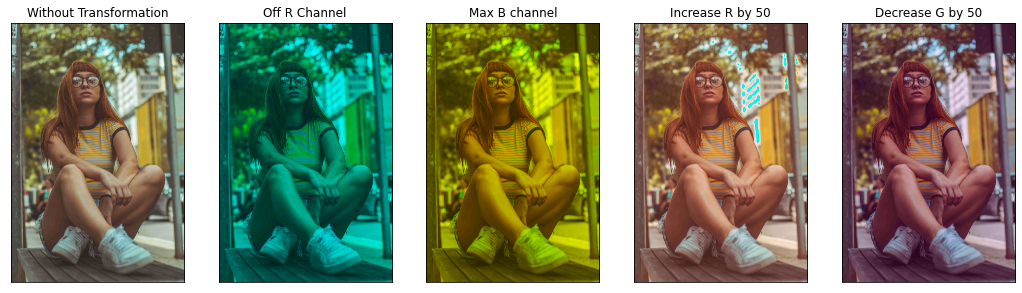

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 5, squeeze = False, figsize = (18, 8)) 
ax[0][0].grid(False) 
ax[0][0].set_xticks([])
ax[0][0].set_yticks([])
ax[0][0].imshow(img_temp)
ax[0][0].set_title('Without Transformation')
list_trans = []
trans_names = []

img_trans = img_temp.copy()
img_trans[:, :, 0] = img_trans[:, :, 0] * 0
list_trans.append(img_trans)
trans_names.append('Off R Channel')

img_trans = img_temp.copy()
img_trans[:, :, 2] = img_trans[:, :, 2] * 256
list_trans.append(img_trans)
trans_names.append('Max B channel')


img_trans = img_temp.copy()
img_trans[:, :, 0] = img_trans[:,:,0] + 30
trans_names.append('Increase R by 50')
list_trans.append(img_trans)

img_trans = img_temp.copy()
img_trans[:, :, 1] = img_trans[:,:,1] - 30
trans_names.append('Decrease G by 50')
list_trans.append(img_trans)

for j, img in enumerate(list_trans) :
    ax[0][j + 1].set_title(trans_names[j])
    ax[0][j + 1].grid(False)
    ax[0][j + 1].set_xticks([])
    ax[0][j + 1].set_yticks([])
    ax[0][j + 1].imshow(img)

E)Kernel filters <br>
Kernel filters are a very popular technique in image processing to sharpen and blur images. These filters work by sliding an n × n matrix across an image with either a Gaussian blur filter, which will result in a blurrier image, or a high contrast vertical or horizontal edge filter which will result in a sharper image along edges. Intuitively, blurring images for Data Augmentation could lead to higher resistance to motion blur during testing. Additionally, sharpening images for Data Augmentation could result in encapsulating more details about objects of interest.

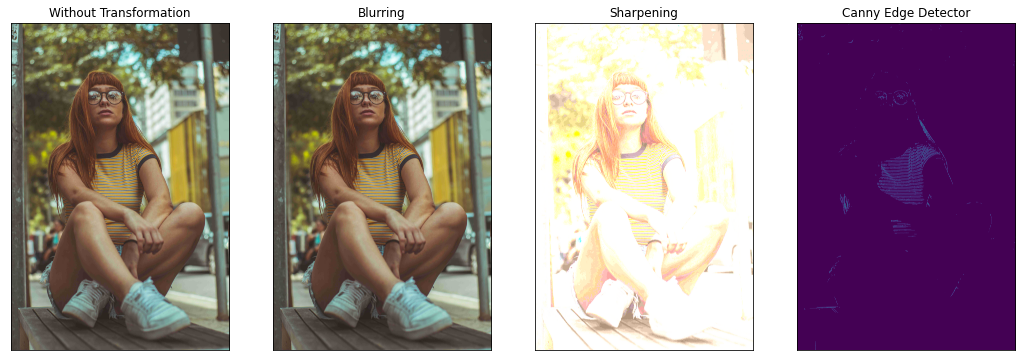

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 4, squeeze = False, figsize = (18, 8)) 
ax[0][0].grid(False) 
ax[0][0].set_xticks([])
ax[0][0].set_yticks([])
ax[0][0].imshow(img_temp)
ax[0][0].set_title('Without Transformation')
list_trans = []
trans_names = []

img_trans = cv2.GaussianBlur(img_temp, (5,5),cv2.BORDER_DEFAULT)
list_trans.append(img_trans)
trans_names.append('Blurring')

kernel = np.array([[-1,-1,-1], 
                       [-1, 12,-1],
                       [-1,-1,-1]])
img_trans = cv2.filter2D(src = img_temp, ddepth = -1, kernel = kernel)
trans_names.append('Sharpening')
list_trans.append(img_trans)

img_trans = cv2.Canny(img_temp, 100, 200)
list_trans.append(img_trans)
trans_names.append('Canny Edge Detector')

for j, img in enumerate(list_trans) :
    ax[0][j + 1].set_title(trans_names[j])
    ax[0][j + 1].grid(False)
    ax[0][j + 1].set_xticks([])
    ax[0][j + 1].set_yticks([])
    ax[0][j + 1].imshow(img)


F)Random erasing <br>
    This augmentation technique is inspired from drop out regularization technique. In real time we could get an image where the object of interest is partially present due to occulsion.If you add these images to the dataset it will make model learn to predict label without having whole part of object. We found many images in the dataset where the shoes, glasses, skirt, top got occluded so our dataset internally has this transformed images present in it and hence we decided not to apply this transformation.



